# Polygon to pois for social housing (v1, not keeping data)

This notebook would originally distribute polygons of interest to points of interest using spatial join (Nodes that intersect social housing polygons would become social housing points of interest).

However, since some polygons do not intersect with nodes, voronoi method was used.
__This notebook was also used to upload the calculated voronoi polygons to database.__

#### __Voronoi distribution method:__
1. Divide area of interest in voronoi polygons using OSMnx nodes (layer santiago_voronoinodes). Keep osmid for which voronoi polygon was formed.
2. Find voronoi polygons that intersect social housing (spatial join)
3. Find unique osmids assigned to those voronoi polygons.
4. From that list of unique osmids, select nodes. Those become pois.
5. Renamed and saved layer (Nodes are already clipped to aoi)

## Import libraries

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

In [16]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to local AND database?
save = False

##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

## Load data

### Load data - Social housing polygons (Has pois data)

In [3]:
# Load data
vivienda_social_dir = "../../../data/external/temporal_todocker/santiago/proximidad/CECYT_CVS_2020_32719.gpkg"
vivienda_social = gpd.read_file(vivienda_social_dir)
vivienda_social = vivienda_social.to_crs("EPSG:4326")

# Filter for data of interest
vivienda_social = vivienda_social[['Total_de_v','geometry']].copy()
vivienda_social.rename(columns={'Total_de_v':'housing'},inplace=True)

# Show
print(vivienda_social.shape)
vivienda_social.head(2)

(4412, 2)


,housing,geometry
0,200,"MULTIPOLYGON (((-70.38324 -23.56441, -70.38263..."
1,11,"MULTIPOLYGON (((-70.37756 -23.60749, -70.37759..."


### Load data - Nodes (Will become pois geometry)

In [5]:
# Area of interest (Run bigger since we can clip data as soon as we know inputs extent)
city = 'AM_Santiago'

# Database schemas and tables (Shouldn't change for this project)
# Area of interest (aoi)
aoi_schema = 'projects_research'
aoi_table = 'santiago_aoi'
# OSMnx Network
network_schema = 'projects_research'
edges_table = 'santiago_edges'
nodes_table = 'santiago_nodes'
projected_crs = 'EPSG:32719'

<Axes: >

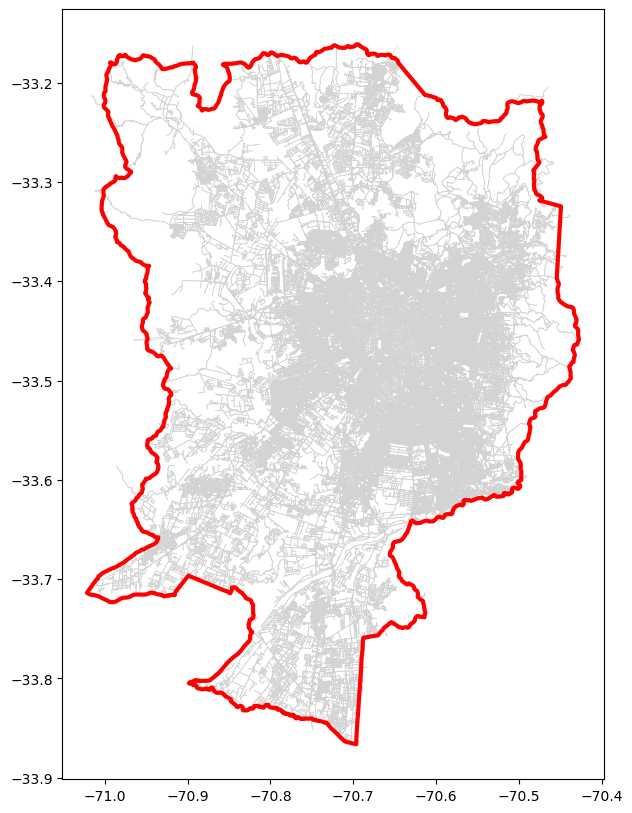

In [6]:
# Area of interest (aoi)
query = f"SELECT * FROM {aoi_schema}.{aoi_table} WHERE \"city\" LIKE \'{city}\'"
aoi = aup.gdf_from_query(query, geometry_col='geometry')
aoi = aoi.set_crs("EPSG:4326")

# OSMnx Network
G, nodes, edges = aup.graph_from_hippo(aoi, network_schema, edges_table, nodes_table, projected_crs)

# Show
fig,ax = plt.subplots(figsize=(10,10))
edges.plot(ax=ax,zorder=1,linewidth=0.5,edgecolor='lightgray')
aoi.plot(ax=ax,facecolor='None',edgecolor='red',linewidth=3)

## Data treatment 1 (Fail) - Social housing to nodes using spatial join.
#### __Problem: Nodes fall outside social housing polygons.__

### Data treatment 1 - Social housing to nodes (Spatial join)

In [7]:
# Clip pois to aoi
source_pois = gpd.sjoin(nodes, vivienda_social)
source_pois = source_pois[['housing','geometry']]

# Show
print(source_pois.shape)
source_pois.head(2)

(23472, 2)


,housing,geometry
osmid,,
266260549,444,POINT (-70.78342 -33.52187)
266260573,444,POINT (-70.78385 -33.52188)


### Data treatment 1 - Confirm joined data

In [25]:
print(len(vivienda_social.housing.unique()))

574


In [26]:
print(len(source_pois.housing.unique()))

425


## Data treatment 2 (Success) - Create and use voronoi distribution

### Data treatment 2 - Create voronoi distribution

<Axes: >

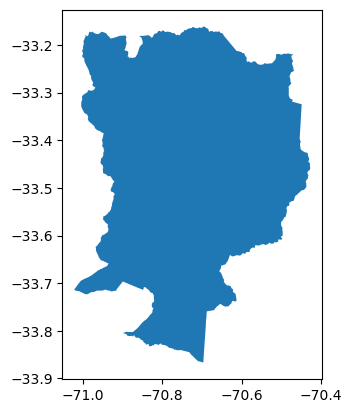

In [7]:
aoi.plot()

In [8]:
nodes_gdf = nodes.reset_index().copy()

# Show
print(nodes_gdf.shape)
nodes_gdf.head(1)

(257999, 5)


,osmid,x,y,street_count,geometry
0,14609420,-70.754779,-33.51598,3,POINT (-70.75478 -33.51598)


In [9]:
voronois_gdf = aup.voronoi_points_within_aoi(aoi, nodes_gdf, points_id_col='osmid',projected_crs=projected_crs)

# Show
print(voronois_gdf.shape)
voronois_gdf.head(1)

Error = 1.02%. Repeating process.
Error = 0.35%. Repeating process.
Error = -0.0%. Admissible.
(257949, 4)


,index_right,osmid,city,geometry
0,121383,2570985396,AM_Santiago,"POLYGON ((-70.48877 -33.22815, -70.49911 -33.2..."


In [10]:
voronois_gdf.drop(columns=['index_right'],inplace=True)

# Show
print(voronois_gdf.shape)
voronois_gdf.head(1)

(257949, 3)


,osmid,city,geometry
0,2570985396,AM_Santiago,"POLYGON ((-70.48877 -33.22815, -70.49911 -33.2..."


In [38]:
if save:
    voronois_gdf.to_file('../../../data/external/temporal_fromjupyter/santiago/nodes_voronoi.gpkg', driver='GPKG')

In [11]:
if save:
    aup.gdf_to_db_slow(voronois_gdf, 'santiago_voronoinodes', 'projects_research', if_exists='replace')

### Data treatment 2 - Use voronoi distribution to find nodes close/in social housing polygons

In [12]:
# Keeps voronois polygons (no clipping, complete) that intersect with social housing polygons.
# If two or more housing polygons intersect the same voronoi polygon, keeps housing data of last processed polygon
# (Will not be using housing data, just unique osmids)
source_polys = gpd.sjoin(voronois_gdf, vivienda_social)

# Show
print(source_polys.shape)
source_polys.head(1)

(38061, 5)


,osmid,city,geometry,index_right,housing
349,428877636,AM_Santiago,"POLYGON ((-70.54112 -33.54045, -70.54120 -33.5...",2454,384


In [57]:
# QGIS review
if save:
    source_polys.to_file('../../../data/external/temporal_fromjupyter/santiago/source_polys_test.gpkg', driver='GPKG')

In [13]:
social_housing_osmids = list(source_polys.osmid.unique())
len(social_housing_osmids)

34639

In [14]:
source_pois = nodes_gdf.loc[nodes_gdf.osmid.isin(social_housing_osmids)]

# Show
print(source_pois.shape)
source_pois.head(1)

(34639, 5)


,osmid,x,y,street_count,geometry
90,266260549,-70.783415,-33.521868,3,POINT (-70.78342 -33.52187)


In [15]:
if save:
    source_pois.to_file('../../../data/external/temporal_fromjupyter/santiago/pois/viv_social.gpkg', driver='GPKG')